In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
plt.style.use("seaborn")

import os
os.chdir(os.path.dirname(os.getcwd()))
print(os.getcwd())

from studytimeboard.utils.gsheet import GoogleSheet
from studytimeboard.data_analysis import *
from studytimeboard.constant import *



/home/congyu/congyu_program/pythons/inits/p_study_time_board


/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/flask_sqlalchemy/__init__.py:834: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  'SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and '


In [2]:
gs = GoogleSheet.read_from(STUDY_TIME_TABLE_NAME)
df_dur = gs.sheet(sheet_name=SHEET1, least_col_name=START_TIME)
df_eve = gs.sheet(sheet_name=SHEET2, least_col_name=NAME)
df = merge_dur_eve(df_dur, df_eve)
    
    
df.head()

,name,date,start_time,end_time
0,Alpha,2020.11.09,11:00,12:00
1,Delta,2020.11.09,11:00,12:00
2,Delta,2020.11.09,08:00,15:00
3,Beta,2020.11.09,08:00,15:00
4,Diqing,2020.11.09,19:00,23:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 0 to 153
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        296 non-null    object
 1   date        296 non-null    object
 2   start_time  296 non-null    object
 3   end_time    296 non-null    object
dtypes: object(4)
memory usage: 11.6+ KB


In [5]:
df_all = add_analysis_columns(df)
df_all.head()

,name,date,start_time,end_time,start_time_datetime,end_time_datetime,minutes,date_datetime,weekday
0,Alpha,2020.11.09,11:00,12:00,1900-01-01 11:00:00,1900-01-01 12:00:00,60.0,2020-11-09,Monday
1,Delta,2020.11.09,11:00,12:00,1900-01-01 11:00:00,1900-01-01 12:00:00,60.0,2020-11-09,Monday
2,Delta,2020.11.09,08:00,15:00,1900-01-01 08:00:00,1900-01-01 15:00:00,420.0,2020-11-09,Monday
3,Beta,2020.11.09,08:00,15:00,1900-01-01 08:00:00,1900-01-01 15:00:00,420.0,2020-11-09,Monday
4,Diqing,2020.11.09,19:00,23:00,1900-01-01 19:00:00,1900-01-01 23:00:00,240.0,2020-11-09,Monday


In [6]:
def to_personal_analysis_table(df, name):
    """

    :param df:
    :param name:
    :return:
    """

    df_r = df.loc[df[NAME] == name, :]
    df_r = df_r.groupby(DATE)[MINUTES].apply(sum)
    df_r = df_r.reset_index()
    
    df_r[DATE_DT] = pd.to_datetime(df_r[DATE])
    df_r[WEEKDAY] = df_r[DATE_DT].dt.day_name()

    return df_r

In [7]:
df_user = to_personal_analysis_table(df_all, "Congyu")
df_user.head()

,date,minutes,date_datetime,weekday
0,2020.11.09,180.0,2020-11-09,Monday
1,2020.11.11,115.0,2020-11-11,Wednesday
2,2020.11.15,140.0,2020-11-15,Sunday
3,2020.11.16,239.0,2020-11-16,Monday
4,2020.11.17,355.0,2020-11-17,Tuesday


In [8]:
df_congyu = df_all.loc[df_all[NAME] == "Congyu", :]
df_congyu.head()

,name,date,start_time,end_time,start_time_datetime,end_time_datetime,minutes,date_datetime,weekday
6,Congyu,2020.11.09,15:30,18:30,1900-01-01 15:30:00,1900-01-01 18:30:00,180.0,2020-11-09,Monday
8,Congyu,2020.11.11,09:30,11:25,1900-01-01 09:30:00,1900-01-01 11:25:00,115.0,2020-11-11,Wednesday
10,Congyu,2020.11.15,11:00,12:30,1900-01-01 11:00:00,1900-01-01 12:30:00,90.0,2020-11-15,Sunday
12,Congyu,2020.11.15,17:05,17:55,1900-01-01 17:05:00,1900-01-01 17:55:00,50.0,2020-11-15,Sunday
17,Congyu,2020.11.16,16:30,16:45,1900-01-01 16:30:00,1900-01-01 16:45:00,15.0,2020-11-16,Monday


In [9]:
def plot_study_stream(df):
    date = df[DATE].tolist()
    ts = df[START_TIME_DT].tolist()
    te = df[END_TIME_DT].tolist()

    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot()

    for i in range(len(df)):
        ax.plot([date[i], date[i]], [ts[i], te[i]], ".-", linewidth=20)

    ax.yaxis.set_major_locator(HourLocator())
    ax.yaxis.set_major_formatter(DateFormatter('%H:%M'))
    
    plt.axhline(y=datetime.strptime("08:00","%H:%M"), color="r", ls=":")
    plt.axhline(y=datetime.strptime("12:30","%H:%M"), color="r", ls=":")
    plt.axhline(y=datetime.strptime("18:30","%H:%M"), color="r", ls=":")
    
    plt.ylim((datetime.strptime("00:00","%H:%M"), datetime.strptime("23:59","%H:%M")))
    plt.gca().invert_yaxis()
    plt.show()

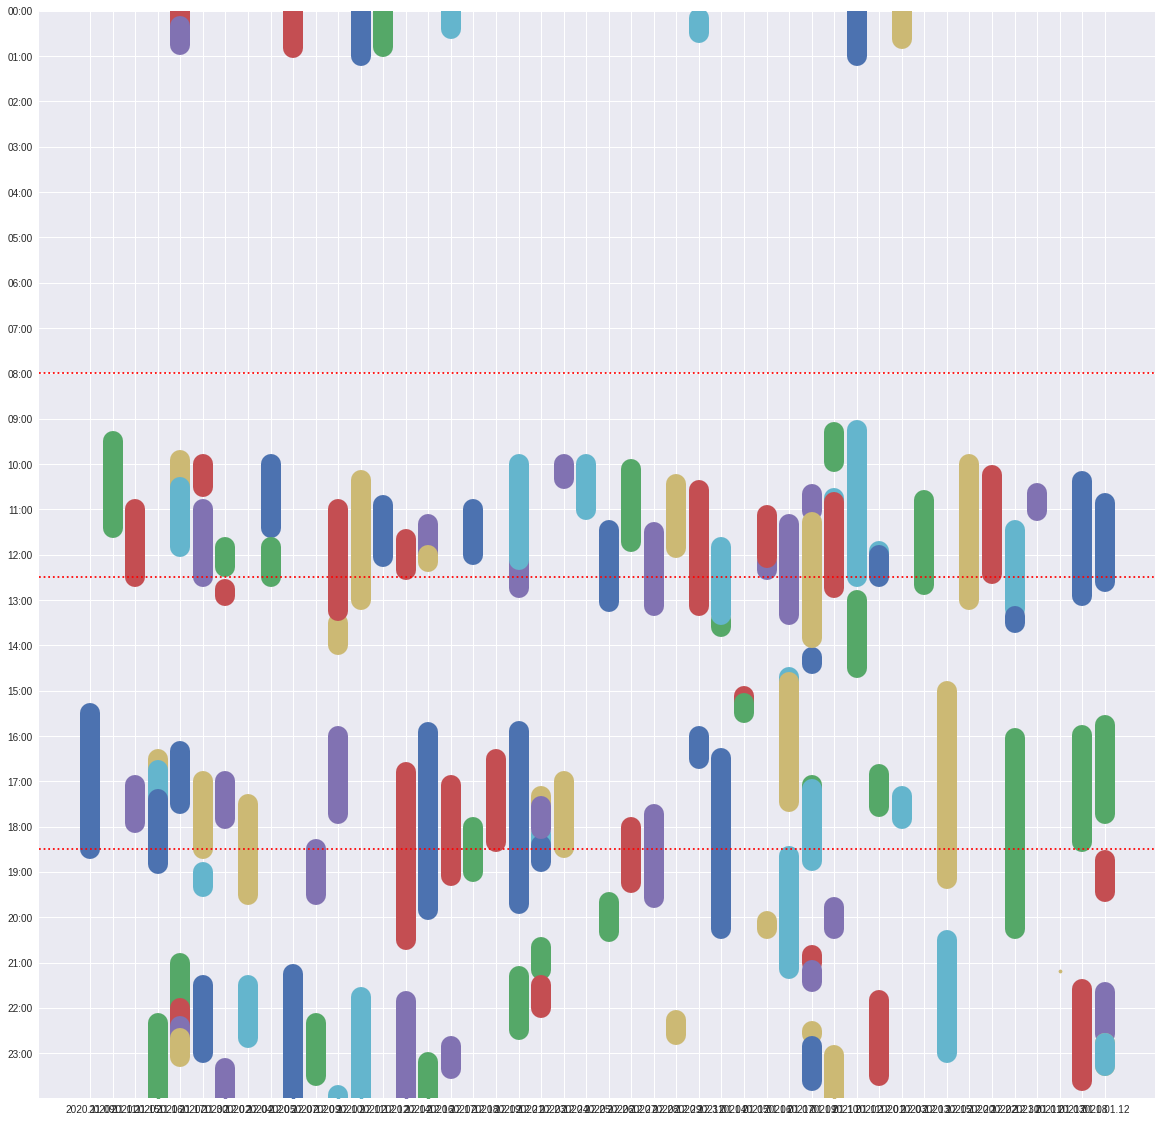

In [10]:
plot_study_stream(df_congyu)

In [13]:
today_str = datetime2date(datetime.today())
df_congyu[TODAY_OR_NOT] = [IS_TODAY if i else NOT_TODAY for i in df_congyu[DATE] == today_str]
df_congyu_today = df_congyu.loc[df_congyu[TODAY_OR_NOT] == IS_TODAY, :]
df_congyu_today.head()

/home/congyu/.virtualenvs/congyuml/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,date,start_time,end_time,start_time_datetime,end_time_datetime,minutes,date_datetime,weekday,today_or_not
141,Congyu,2021.01.12,10:52,12:36,1900-01-01 10:52:00,1900-01-01 12:36:00,104.0,2021-01-12,Tuesday,is_today
145,Congyu,2021.01.12,15:46,17:44,1900-01-01 15:46:00,1900-01-01 17:44:00,118.0,2021-01-12,Tuesday,is_today
146,Congyu,2021.01.12,18:44,19:27,1900-01-01 18:44:00,1900-01-01 19:27:00,43.0,2021-01-12,Tuesday,is_today
147,Congyu,2021.01.12,21:39,22:34,1900-01-01 21:39:00,1900-01-01 22:34:00,55.0,2021-01-12,Tuesday,is_today
148,Congyu,2021.01.12,22:47,23:17,1900-01-01 22:47:00,1900-01-01 23:17:00,30.0,2021-01-12,Tuesday,is_today


In [24]:
def plot_study_stream_singleday(df):
    
    ts = df[START_TIME_DT].tolist()
    te = df[END_TIME_DT].tolist()

    fig = plt.figure(figsize=(20, 1))
    ax = plt.subplot()

    for i in range(len(df)):
        ax.plot([ts[i], te[i]], [0, 0], ".-", linewidth=20)

    ax.xaxis.set_major_locator(HourLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    
    plt.axvline(x=datetime.strptime("08:00","%H:%M"), color="r", ls=":")
    plt.axvline(x=datetime.strptime("12:30","%H:%M"), color="r", ls=":")
    plt.axvline(x=datetime.strptime("18:30","%H:%M"), color="r", ls=":")
    
    plt.xlim((datetime.strptime("00:00","%H:%M"), datetime.strptime("23:59","%H:%M")))
    plt.yticks([])
    plt.show()

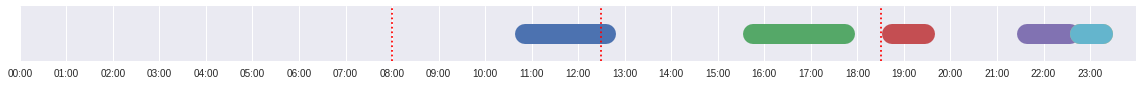

In [25]:
plot_study_stream_singleday(df_congyu_today)